In [1]:
# model adapted from https://keras.io/examples/vision/mnist_convnet/

In [2]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Softmax, Dense, ReLU, Dropout
from tensorflow.keras import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
# Convert y_train into one-hot format
temp = []
for i in range(len(y_train)):
    temp.append(to_categorical(y_train[i], num_classes=10))
y_train = np.array(temp)
# Convert y_test into one-hot format
temp = []
for i in range(len(y_test)):    
    temp.append(to_categorical(y_test[i], num_classes=10))
y_test = np.array(temp)

In [5]:
#reshaping
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype(np.float32)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype(np.float32)

In [6]:
inputs = Input(shape=(28,28,1))
out = Conv2D(4, 3)(inputs)
out = ReLU()(out)
out = MaxPooling2D()(out)
out = Conv2D(8, 3)(out)
out = ReLU()(out)
out = MaxPooling2D()(out)
out = Flatten()(out)
out = Dropout(0.5)(out)
out = Dense(10, activation=None)(out)
out = Softmax()(out)
full_model = Model(inputs, out)

In [7]:
full_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 4)         40        
                                                                 
 re_lu (ReLU)                (None, 26, 26, 4)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 4)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 8)         296       
                                                                 
 re_lu_1 (ReLU)              (None, 11, 11, 8)         0         
                                                             

In [8]:
full_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc']
    )

In [9]:
full_model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/100


2022-12-11 01:15:19.413108: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


469/469 [==============================] - 4s 7ms/step - loss: 15.1837 - acc: 0.3464 - val_loss: 1.1383 - val_acc: 0.6266
Epoch 2/100
469/469 [==============================] - 3s 7ms/step - loss: 1.3581 - acc: 0.5707 - val_loss: 0.6394 - val_acc: 0.8276
Epoch 3/100
469/469 [==============================] - 3s 7ms/step - loss: 0.9698 - acc: 0.7040 - val_loss: 0.4940 - val_acc: 0.8754
Epoch 4/100
469/469 [==============================] - 3s 6ms/step - loss: 0.8298 - acc: 0.7487 - val_loss: 0.4032 - val_acc: 0.8965
Epoch 5/100
469/469 [==============================] - 3s 6ms/step - loss: 0.7570 - acc: 0.7679 - val_loss: 0.3625 - val_acc: 0.9054
Epoch 6/100
469/469 [==============================] - 3s 7ms/step - loss: 0.6996 - acc: 0.7855 - val_loss: 0.3243 - val_acc: 0.9122
Epoch 7/100
469/469 [==============================] - 3s 6ms/step - loss: 0.6625 - acc: 0.7960 - val_loss: 0.3025 - val_acc: 0.9196
Epoch 8/100
469/469 [==============================] - 3s 6ms/step - loss: 0.617

In [10]:
model = Model(full_model.input, full_model.layers[-2].output)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 4)         40        
                                                                 
 re_lu (ReLU)                (None, 26, 26, 4)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 4)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 8)         296       
                                                                 
 re_lu_1 (ReLU)              (None, 11, 11, 8)         0         
                                                           

In [11]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(X_train).batch(1).take(100):
    # Model has only one input so each data point has one element.
    yield [input_value]

In [12]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.inference_input_type = tf.int8
# converter.inference_output_type = tf.int8
converter._experimental_disable_per_channel = True
tflite_quant_model = converter.convert()

INFO:tensorflow:Assets written to: /var/folders/gt/sg3v8rd13l52jx91mfbgzbfc0000gn/T/tmpu47z18n5/assets


INFO:tensorflow:Assets written to: /var/folders/gt/sg3v8rd13l52jx91mfbgzbfc0000gn/T/tmpu47z18n5/assets
/Users/sty/miniforge3/envs/tf-cpu/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-12-11 01:20:45.994077: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-11 01:20:45.994091: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-12-11 01:20:45.994249: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/gt/sg3v8rd13l52jx91mfbgzbfc0000gn/T/tmpu47z18n5
2022-12-11 01:20:45.995189: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-12-11 01:20:45.995195: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info 

In [13]:
import pathlib

tflite_models_dir = pathlib.Path("./")
# tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"mnist_convnet_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)

5944

In [14]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
  global X_test

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = X_test[test_image_index]
    test_label = y_test[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

  return predictions

In [15]:
## Helper function to test the models on one image
def test_model(tflite_file, test_image_index, model_type):
  global y_test

  predictions = run_tflite_model(tflite_file, [test_image_index])

  plt.imshow(X_test[test_image_index])
  template = model_type + " Model \n True:{true}, Predicted:{predict}"
  _ = plt.title(template.format(true= str(y_test[test_image_index].argmax()), predict=str(predictions[0])))
  plt.grid(False)

INFO: Initialized TensorFlow Lite runtime.
INFO: Applying 1 TensorFlow Lite delegate(s) lazily.


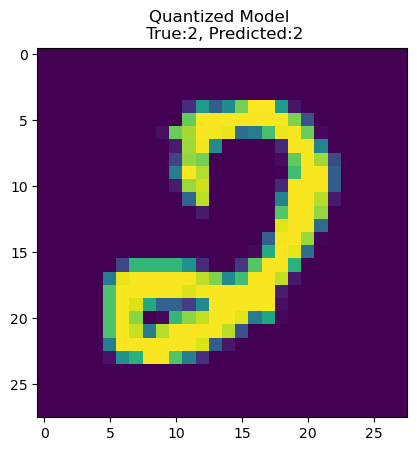

In [16]:
# Change this to test a different image
test_image_index = 400
test_model(tflite_model_quant_file, test_image_index, model_type="Quantized")

In [17]:
# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
  global X_test
  global y_test

  test_image_indices = range(X_test.shape[0])
  predictions = run_tflite_model(tflite_file, test_image_indices)

  accuracy = (np.sum(np.argmax(y_test, axis=1)== predictions) * 100) / len(X_test)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(X_test)))

In [18]:
evaluate_model(tflite_model_quant_file, model_type="Quantized")

INFO: Applying 1 TensorFlow Lite delegate(s) lazily.


Quantized model accuracy is 97.9500% (Number of test samples=10000)


In [19]:
[l.name for l in model.layers]

['input_1',
 'conv2d',
 're_lu',
 'max_pooling2d',
 'conv2d_1',
 're_lu_1',
 'max_pooling2d_1',
 'flatten',
 'dropout',
 'dense']

In [20]:
in_json = {}
scale = {}

In [21]:
'''
Create interpreter, allocate tensors
'''
tflite_interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
tflite_interpreter.allocate_tensors()

'''
Check input/output details
'''
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])
print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

'''
This gives a list of dictionaries. 
'''
tensor_details = tflite_interpreter.get_tensor_details()

for dict in tensor_details:
    i = dict['index']
    tensor_name = dict['name']
    scales = dict['quantization'][0]
    zero_points = dict['quantization'][1]
    tensor = tflite_interpreter.tensor(i)()

    # print(i, type, tensor_name, scales, zero_points)
    # print(dict)
    if "model_1/conv2d/Conv2D" == tensor_name:
        weights = tensor
        weights = np.rollaxis(weights, 0,4)
        in_json['conv2d_weights'] = weights
        scale['conv2d_weights'] = scales
        print('conv2d_weights', weights.shape, scales)
    elif "model_1/conv2d/BiasAdd/ReadVariableOp" == tensor_name:
        biases = tensor
        in_json['conv2d_bias'] = biases.flatten().tolist()
        scale['conv2d_bias'] = scales
        print('conv2d_bias', biases.shape, biases, scales)
    elif "model_1/conv2d_1/Conv2D" == tensor_name:
        weights = tensor
        weights = np.rollaxis(weights, 0,4)
        in_json['conv2d_1_weights'] = weights
        scale['conv2d_1_weights'] = scales
        print('conv2d_1_weights', weights.shape, scales)
    elif "model_1/conv2d_1/BiasAdd/ReadVariableOp" == tensor_name:
        biases = tensor
        in_json['conv2d_1_bias'] = biases.flatten().tolist()
        scale['conv2d_1_bias'] = scales
        print('conv2d_1_bias', biases.shape, biases, scales)
    elif "model_1/dense/MatMul" == tensor_name:
        weights = tensor
        weights = np.rollaxis(weights, 1)
        in_json['dense_weights'] = weights
        scale['dense_weights'] = scales
        print('dense_weights', weights.shape, scales)
    elif "model_1/dense/BiasAdd/ReadVariableOp" == tensor_name:
        biases = tensor
        in_json['dense_bias'] = biases.flatten().tolist()
        scale['dense_bias'] = scales
        print('dense_bias', biases.shape, biases, scales)

== Input details ==
name: serving_default_input_1:0
shape: [ 1 28 28  1]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [ 1 10]
type: <class 'numpy.float32'>
dense_bias (10,) [ 1882  7290 -3220 -3212 -2238 -5057   964 -6501  6977   323] 0.00040966662345454097
dense_weights (200, 10) 0.013641951605677605
conv2d_1_bias (8,) [ -87  265   -2 -179   -5 -356   -3  -14] 0.0008817124180495739
conv2d_1_weights (3, 3, 4, 8) 0.007074496243149042
conv2d_bias (4,) [-359   -2   -1    2] 0.0019289110787212849
conv2d_weights (3, 3, 1, 4) 0.0019289110787212849


INFO: Applying 1 TensorFlow Lite delegate(s) lazily.


In [22]:
in_json.keys()

dict_keys(['dense_bias', 'dense_weights', 'conv2d_1_bias', 'conv2d_1_weights', 'conv2d_bias', 'conv2d_weights'])

In [23]:
scale

{'dense_bias': 0.00040966662345454097,
 'dense_weights': 0.013641951605677605,
 'conv2d_1_bias': 0.0008817124180495739,
 'conv2d_1_weights': 0.007074496243149042,
 'conv2d_bias': 0.0019289110787212849,
 'conv2d_weights': 0.0019289110787212849}

In [24]:
in_json['conv2d_weights'] = in_json['conv2d_weights']*(scale['conv2d_weights']/scale['conv2d_bias'])
print(in_json['conv2d_weights'][0].flatten())
in_json['conv2d_weights'] = in_json['conv2d_weights'].round().astype(int).flatten().tolist()
in_json['conv2d_weights'][:12]

[   1.   -2. -127.    7.   10.   -2.  -33.    2.   22.  -11.    6.    9.]


[1, -2, -127, 7, 10, -2, -33, 2, 22, -11, 6, 9]

In [25]:
in_json['conv2d_1_weights'] = in_json['conv2d_1_weights']*(scale['conv2d_1_weights']/scale['conv2d_1_bias'])
print(in_json['conv2d_1_weights'][0][0][0].flatten())
in_json['conv2d_1_weights'] = in_json['conv2d_1_weights'].round().astype(int).flatten().tolist()
in_json['conv2d_1_weights'][:8]

[ -8.02358694  -8.02358694  24.07076082 -48.14152165 -24.07076082
 160.47173882  16.04717388  40.1179347 ]


[-8, -8, 24, -48, -24, 160, 16, 40]

In [26]:
in_json['dense_weights'] = in_json['dense_weights']*(scale['dense_weights']/scale['dense_bias'])
print(in_json['dense_weights'][0].flatten())
in_json['dense_weights'] = in_json['dense_weights'].round().astype(int).flatten().tolist()
in_json['dense_weights'][:10]

[ -266.40103586  -133.20051793   632.70246017   366.30142431
  -566.1022012  -1431.90556775   266.40103586   266.40103586
 -1565.10608568 -3429.91333669]


[-266, -133, 633, 366, -566, -1432, 266, 266, -1565, -3430]

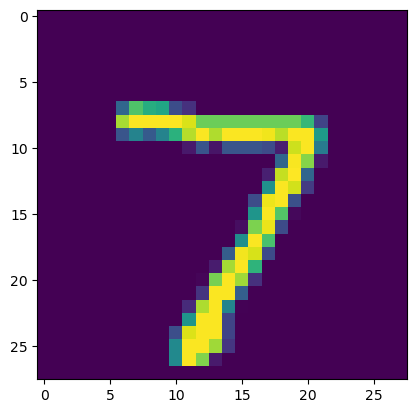

In [27]:
X = X_test[[0]]
plt.imshow(X[0])

In [28]:
y = model.predict(X)
y

1/1 [==============================] - 0s 66ms/step


array([[ -2.8180332 ,  -7.8118086 ,   3.4019184 ,   0.27658188,
        -14.287446  , -11.729616  , -29.31386   ,  12.413387  ,
         -5.9041095 ,  -2.54478   ]], dtype=float32)

In [29]:
in_json["in"] = X.astype(int).flatten().tolist(),

In [30]:
out_json = {
    "scale": scale['conv2d_bias']*scale['conv2d_1_bias']*scale['dense_bias'],
    "out": y.flatten().tolist(),
    "label": int(y_test[0].argmax())
}
out_json

{'scale': 6.967384006397277e-10,
 'out': [-2.818033218383789,
  -7.8118085861206055,
  3.401918411254883,
  0.27658188343048096,
  -14.287446022033691,
  -11.729616165161133,
  -29.313859939575195,
  12.413387298583984,
  -5.904109477996826,
  -2.5447800159454346],
 'label': 7}

In [31]:
import json

In [32]:
with open("mnist_convnet_input.json", "w") as f:
    json.dump(in_json, f)

In [33]:
with open("mnist_convnet_output.json", "w") as f:
    json.dump(out_json, f)

In [34]:
# conv2d_weights mape
(np.abs((model.weights[0].numpy().flatten()-np.array(in_json['conv2d_weights'])*scale['conv2d_bias'])/model.weights[0].numpy().flatten())).mean()

0.04827827630835111

In [35]:
# conv2d_bias mape
(np.abs((model.weights[1].numpy().flatten()-np.array(in_json['conv2d_bias'])*scale['conv2d_bias'])/model.weights[1].numpy().flatten())).mean()

0.3162336868466024

In [36]:
# conv2d_1_weights mape
(np.abs((model.weights[2].numpy().flatten()-np.array(in_json['conv2d_1_weights'])*scale['conv2d_1_bias'])/model.weights[2].numpy().flatten())).mean()

0.07922936952167237

In [37]:
# conv2d_1_bias mape
(np.abs((model.weights[3].numpy().flatten()-np.array(in_json['conv2d_1_bias'])*scale['conv2d_1_bias'])/model.weights[3].numpy().flatten())).mean()

0.0320445054168509

In [38]:
# dense_weights mape
(np.abs((model.weights[4].numpy().flatten()-np.array(in_json['dense_weights'])*scale['dense_bias'])/model.weights[4].numpy().flatten())).mean()

0.09156827584568371

In [39]:
# dense_bias mape
(np.abs((model.weights[5].numpy().flatten()-np.array(in_json['dense_bias'])*scale['dense_bias'])/model.weights[5].numpy().flatten())).mean()

0.00021858932254896152